In [1]:
from collections import defaultdict, Counter, namedtuple
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import random
import copy
from os import listdir
import scipy.sparse as sparse

In [50]:
chrom = 'X'
ihart_family_sizes = [3, 4, 5, 6]
ihart_phase_dir = '../phased_ihart'
ssc_family_sizes = [3, 4]
ssc_phase_dir = '../phased_ssc'

PAR1X_end = 2699520
PAR2X_start = 154931044

In [51]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

# Filter Families


In [52]:
family_to_individuals = dict()

def load_families(phase_dir, family_sizes):
    family_to_chroms = defaultdict(set)
    
    print(chrom, end=' ')

    for j in family_sizes:
        try:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    family_to_chroms[family_key].add(chrom)
                    family_to_individuals[family_key] = pieces[1:(1+j)]
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'family size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)

    families_to_include = set(family_to_chroms.keys())
    print('Families with all chroms', len(families_to_include))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    return families_to_include
ihart_families = load_families(ihart_phase_dir, ihart_family_sizes)
ssc_families = load_families(ssc_phase_dir, ssc_family_sizes)

X Families with all chroms 805
Counter({1: 805})
X Families with all chroms 518
Counter({1: 518})


In [53]:
# filter SSC to have only males
ssc_families = [famkey for famkey in ssc_families if len(family_to_individuals[famkey])==4 and child_id_to_sex[family_to_individuals[famkey][2]] == '1' and child_id_to_sex[family_to_individuals[famkey][3]] == '1']
print(len(ssc_families))



206


In [54]:
ihart_individuals = sorted(sum([family_to_individuals[k] for k in ihart_families], []))
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])
ssc_individuals = sorted(sum([family_to_individuals[k] for k in ssc_families], []))
ssc_ind_to_index = dict([(x, i) for i, x in enumerate(ssc_individuals)])

# Read in deletions


In [55]:
Deletion = namedtuple('Deletion', ['family', 'chrom', 'start_pos', 'end_pos', 'length', 'opt_start_pos', 'opt_end_pos', 'trans', 'notrans', 
                                      'family_size', 'is_mat', 'is_pat', 'state', 'dataset', 'supporting_sites'])



In [56]:
from collections import defaultdict

def read_deletions(chrom, phase_dir, family_sizes, families, dataset):
    deletions = []

    for j in family_sizes:
            
        # load deletions
        family_to_states = defaultdict(list)
        family_to_pos = defaultdict(list)
        family_to_indices = defaultdict(list)
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in families:
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    start_index, end_index = [int(x) for x in pieces[(4+(j*2)):(6+(j*2))]]
                    assert end_pos >= start_pos
                        
                    # if a segment is never inherited, we don't know if it has a deletion or not
                    if state[0] == 0 and state[1] == 0:
                        pass
                    else:
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                            state[0] = -1
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                            state[1] = -1
                    if state[2] == 0 and state[3] == 0:
                        pass
                    else:
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                            state[2] = -1
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                            state[3] = -1

                    family_to_states[family_key].append(state)
                    family_to_pos[family_key].append((start_pos, end_pos))
                    family_to_indices[family_key].append((start_index, end_index))

        # for each family, detect deletion transmission
        for family_key, states in family_to_states.items():
            states = np.asarray(states)
            assert np.all(states[0, :4] != 0)
            assert np.all(states[-1, :4] != 0)
            positions = np.asarray(family_to_pos[family_key])
            pos_indices = np.asarray(family_to_indices[family_key])
            inds = family_to_individuals[family_key]
            
            if child_id_to_sex[inds[2]] == '2':
                # if the first child is a girl, then p1 is dad's X and p2 is his Y
                dad_x = 2
            else:
                # otherwise, p2 is dad's X and p1 is his Y
                dad_x = 3

            # for each ancestral chromosome
            for anc in range(4):
                is_mat = anc==0 or anc==1
                is_pat = anc==2 or anc==3
                    
                start_indices = np.where((states[:-1, anc] != 0) & (states[1:, anc] == 0))[0]+1
                end_indices = np.where((states[:-1, anc] == 0) & (states[1:, anc] != 0))[0]+1
                for s_ind, e_ind in zip(start_indices, end_indices):
                    
                    # check if parental double deletion
                    if is_mat:
                        is_double = np.all(states[s_ind, :2]==0)
                    else:
                        is_double = np.all(states[s_ind, 2:4]==0)
        
                    # check if recombination event occured and that inheritance state is known
                    has_recomb = False
                    if is_mat:
                        indices = np.arange(4, states.shape[1]-1, 2)
                    else:
                        indices = np.arange(5, states.shape[1]-1, 2)
                        
                    inh_known = np.all(states[s_ind:e_ind, indices] != -1)
                        
                    for i in range(s_ind, e_ind):
                        if np.any(states[i, indices] != states[s_ind, indices]):
                            has_recomb = True
                            
                    # check if in ok region
                    ok_region = np.all(states[s_ind:e_ind, -1] == 0)
                    
                    # check if we're in the PAR
                    in_par = (positions[s_ind, 0] <= PAR1X_end) or (PAR2X_start <= positions[e_ind-1, 1])
                    
                    if ok_region and inh_known and (not has_recomb) and (is_mat or anc==dad_x): #and (not in_par) :
                        start_pos, end_pos = positions[s_ind, 0], positions[e_ind-1, 1]
                        start_pos_index, end_pos_index = pos_indices[s_ind, 0], pos_indices[e_ind-1, 1]
                        
                        # find boundaries of the deletion
                        #print(s_ind, e_ind)
                        opt_start_index = s_ind
                        while states[opt_start_index, anc] != 1 and opt_start_index > 0:
                            opt_start_index -= 1
                        opt_start_pos = positions[opt_start_index+1, 0]
                        
                        opt_end_index = e_ind
                        while(states[opt_end_index, anc]) != 1 and opt_end_index < states.shape[0]-1:
                            opt_end_index += 1
                        opt_end_pos = positions[e_ind-1, 1]
                        
                        assert start_pos <= end_pos
                        assert opt_start_pos <= start_pos
                        assert end_pos <= opt_end_pos
                        
                        state = states[s_ind, :]
                    
                        # children
                        trans, notrans = [], []
                        for k, child in zip(range(2, j), inds[2:]):
                            mom_s, dad_s = state[(2*k):(2*(k+1))]

                            if is_mat:
                                assert mom_s != -1
                                if anc==mom_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)
                            if is_pat:
                                assert dad_s != -1
                                if anc==2+dad_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)

                        if (len(trans) + len(notrans) == j-2) and (len(trans) > 0):
                            deletions.append(Deletion(family_key, chrom, start_pos, end_pos, end_pos-start_pos+1, 
                                                    opt_start_pos, opt_end_pos,
                                                    tuple(trans), tuple(notrans), j, is_mat, is_pat,
                                                    tuple(states[s_ind, :]), dataset,
                                                    end_pos_index-start_pos_index+1))
                        
    # sort deletions
    deletions = sorted(deletions, key=lambda x: x.start_pos)
    return deletions



In [57]:
class DeletionCollection:
    def __init__(self, deletion, matches):
        self.deletion = deletion
        self.matches = matches

def create_collections(deletions):
    collections = []
    
    starts = np.array([d.start_pos for d in deletions])
    stops = np.array([d.end_pos for d in deletions])

    ordered_start_indices = np.argsort(starts)
    ordered_starts = starts[ordered_start_indices]
    ordered_stop_indices = np.argsort(stops)
    ordered_stops = stops[ordered_stop_indices]
        
    insert_starts_in_stops = np.searchsorted(ordered_stops, starts)
    insert_stops_in_starts = np.searchsorted(ordered_starts, stops, side='right')
        
    indices = np.ones((len(deletions),), dtype=bool)

    for del_index, main_d in enumerate(deletions):
        indices[:] = True
        indices[ordered_stop_indices[:insert_starts_in_stops[del_index]]] = False
        indices[ordered_start_indices[insert_stops_in_starts[del_index]:]] = False

        collections.append(DeletionCollection(main_d, [deletions[j] for j in np.where(indices)[0]]))
    return collections



In [58]:
def prune_deletions(collections, share_cutoff=0.8):    
    # first, prune deletions that don't overlap with the main deletion by share_cutoff
    for c in collections:
        lengths = np.array([d.length for d in c.matches])
        overlaps1 = np.array([min(d.end_pos, c.deletion.end_pos)-max(d.start_pos, c.deletion.start_pos)+1 for d in c.matches])
        overlaps2 = np.array([min(d.opt_end_pos, c.deletion.end_pos)-max(d.opt_start_pos, c.deletion.start_pos)+1 for d in c.matches])
        c.matches = set([c.matches[j] for j in np.where((overlaps1 > 0) & (overlaps2 >= share_cutoff*c.deletion.length))[0]])
    return collections

def prune_collections(collections, share_cutoff=0.8):
        
    deletion_to_index = dict([(x.deletion, i) for i, x in enumerate(collections)])
    
    # now, get rid of collections that are nearly identical to other collections
    for j in np.flip(np.argsort([sum([len(d.trans)+len(d.notrans) for d in c.matches]) for i, c in enumerate(collections)])):
        c = collections[j]
        if c is not None:
            for d in c.matches:
                if (c.deletion != d) and (d in deletion_to_index) and (collections[deletion_to_index[d]] is not None):
                    index = deletion_to_index[d]
                    other_c = collections[index]
                    overlap = len(set(c.matches) & set(other_c.matches))
                    if (overlap >= share_cutoff*len(c.matches)) & (overlap >= share_cutoff*len(other_c.matches)):
                        collections[index] = None
    print('removing %d of %d' % (len([x for x in collections if x is None]), len(collections)))
    collections = [x for x in collections if x is not None]
    return collections





In [60]:
print(chrom, end=' ')
    
ihart_deletions = read_deletions(chrom, ihart_phase_dir, ihart_family_sizes, ihart_families, 'iHART')
print('id', end=' ')
    
ssc_deletions = read_deletions(chrom, ssc_phase_dir, ssc_family_sizes, ssc_families, 'SSC')
print('sd', end=' ')
    
deletions = sorted(ihart_deletions + ssc_deletions, key=lambda x: x.start_pos)
#deletions = sorted(ihart_deletions, key=lambda x: x.start_pos)

collections = create_collections(deletions)
print('c', end=' ')
    
collections = prune_deletions(collections)
print('p', end=' ')
    
collections = prune_collections(collections)
print(len(collections))
    
all_collections = collections  
    

X id sd c p removing 95177 of 109690
14513


In [61]:
ind_indices = np.ones((len(all_collections),), dtype=bool)
#ind_indices = np.asarray([c.deletion.length>500 for c in all_collections])
#ind_indices = np.asarray(num_support)>2

# Look at deletions

min length 2 max length 1156115 num 14513 median 105.0


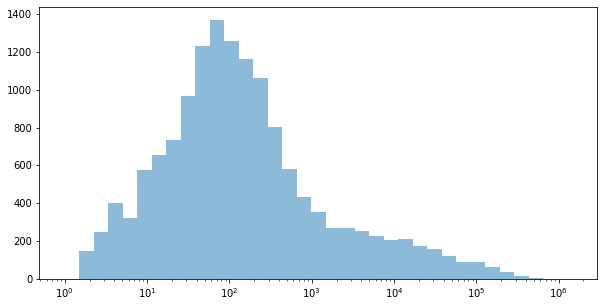

In [62]:
import math

lengths = [all_collections[i].deletion.length for i in np.where(ind_indices)[0]]


plt.figure(figsize=(10, 5))
base = 1.5
max_length = max(lengths) 
min_length = min(lengths) 
print('min length', min(lengths) , 'max length', max(lengths) , 'num', len(lengths), 'median', np.median(lengths))

plt.hist(lengths, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.gca().set_xscale("log")
plt.show()

AU0822.AU082201.AU082202 ['AU082201', 'AU082202', 'AU082203', 'AU082204']


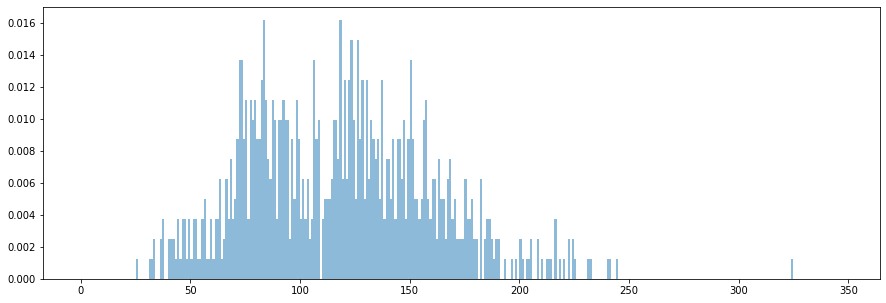

In [63]:
plt.figure(figsize=(15, 5))
num_dels_ihart = [len([x for x in deletions if x.family == famkey]) for famkey in sorted(ihart_families)]
plt.hist(num_dels_ihart, 
         alpha=0.5, density=True, bins=range(0, max(num_dels_ihart)))
#num_dels_ssc = [len([x for x in deletions if x.family == famkey]) for famkey in sorted(ssc_families)]
#plt.hist(num_dels_ssc, 
#         alpha=0.5, density=True, bins=range(0, max(num_dels_ssc)))
#print(max(num_dels_ihart), max(num_dels_ssc))
famkey = sorted(ihart_families)[np.argmax(num_dels_ihart)]
print(famkey, family_to_individuals[famkey])
plt.show()

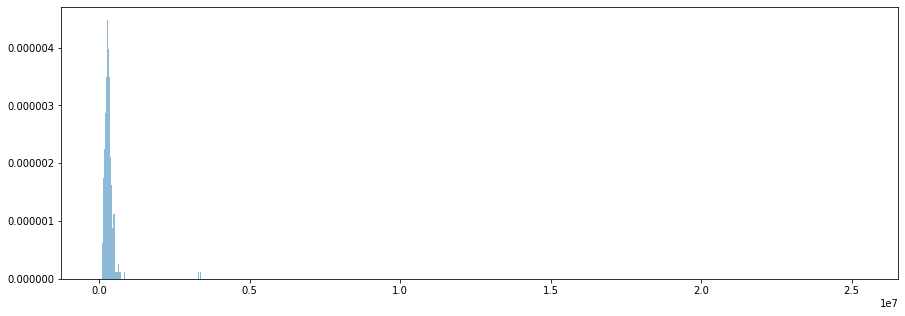

In [64]:
plt.figure(figsize=(15, 5))
num_base_ihart = [sum([x.length for x in deletions if x.family == famkey]) for famkey in sorted(ihart_families)]
plt.hist(num_base_ihart, 
         alpha=0.5, density=True, bins=range(0, max(num_base_ihart), 10000))
#num_base_ssc = [sum([x.length for x in deletions if x.family == famkey]) for famkey in sorted(ssc_families)]
#plt.hist(num_base_ssc, 
#         alpha=0.5, density=True, bins=range(0, max(num_base_ssc), 10000))
#print(max(num_base_ihart), max(num_base_ssc))

plt.show()

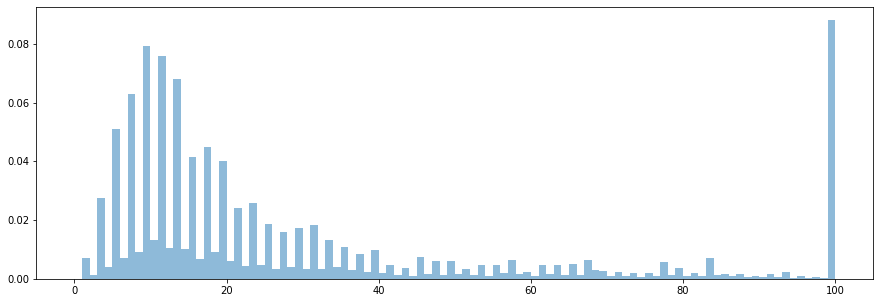

In [65]:
plt.figure(figsize=(15, 5))
num_support_ihart = np.clip([x.supporting_sites for x in deletions if x.family in ihart_families], None, 100)
plt.hist(num_support_ihart, 
         alpha=0.5, density=True, bins=range(0, max(num_support_ihart)+1))
#num_support_ssc = np.clip([x.supporting_sites for x in deletions if x.family in ssc_families], None, 100)
#plt.hist(num_support_ssc, 
#         alpha=0.5, density=True, bins=range(0, max(num_support_ssc)+1))
#print(max(num_support_ihart), max(num_support_ssc))

plt.show()

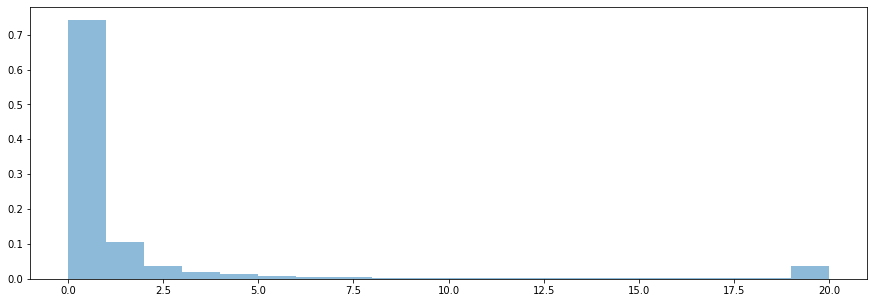

In [66]:
plt.figure(figsize=(15, 5))
plt.hist(np.clip(num_support, None, 20), alpha=0.5, density=True, bins=range(21))

plt.show()

# Test maternal transmission rates

In [67]:
def create_contingency(collections, family_sizes, filter_child, verbose=True):
    # chrom, collection, family_size, notrans/trans
    contingency = np.zeros((len(collections), len(family_sizes), 2))
    familysize_to_index = dict([(x, i) for i, x in enumerate(family_sizes)])
    if verbose:
        print(chrom, end=' ')
    for j, c in enumerate(collections):
        for k, s in enumerate(family_sizes):
            contingency[j, k, 0] = sum([len([x for x in d.notrans if filter_child(x, d.is_mat, d.dataset)]) for d in c.matches if d.family_size==s])
            contingency[j, k, 1] = sum([len([x for x in d.trans if filter_child(x, d.is_mat, d.dataset)]) for d in c.matches if d.family_size==s])
    return contingency

#ihart
contingency_ihart_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and dataset=='iHART')
contingency_ihart_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and dataset=='iHART')

contingency_ihart_aff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='1' and dataset=='iHART')
contingency_ihart_unaff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='1' and dataset=='iHART')

contingency_ihart_aff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='2' and dataset=='iHART')
contingency_ihart_unaff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='2' and dataset=='iHART')

contingency_ihart_all = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: is_mat and dataset=='iHART')

#ssc
contingency_ssc_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and dataset=='SSC')
contingency_ssc_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and dataset=='SSC')

contingency_ssc_aff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='1' and dataset=='SSC')
contingency_ssc_unaff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='1' and dataset=='SSC')

contingency_ssc_aff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='2' and dataset=='SSC')
contingency_ssc_unaff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='2' and dataset=='SSC')

#both
contingency_both_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat)
contingency_both_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat)

contingency_both_aff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='1')
contingency_both_unaff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='1')

contingency_both_aff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='2')
contingency_both_unaff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='2')



X X X X X X X X X X X X X X X X X X X 

In [68]:
cached_pvalue = dict()
ps = [None, None, None] + [pow(2, c-1)/(pow(2, c)-1) for c in range(1, 6)]
print(ps)

def calc_pvalue(trans, notrans, m):
    k = (trans, notrans, m)
    if k not in cached_pvalue:
        cached_pvalue[k] = (scipy.stats.binom_test(trans, trans+notrans, ps[m], alternative='greater'),
                           scipy.stats.binom_test(trans, trans+notrans, ps[m], alternative='less'))
        
    return cached_pvalue[k]

[None, None, None, 1.0, 0.6666666666666666, 0.5714285714285714, 0.5333333333333333, 0.5161290322580645]


In [69]:
def combine_pvalues(pvalues):
    comb_p = [np.nan, np.nan]
    indices = ~np.isnan(pvalues[:, 0])
    if np.sum(indices) > 0:
        comb_p[0] = scipy.stats.combine_pvalues(pvalues[indices, 0], method='fisher')[1]
    indices = ~np.isnan(pvalues[:, 1])
    if np.sum(indices) > 0:
        comb_p[1] = scipy.stats.combine_pvalues(pvalues[indices, 1], method='fisher')[1]
    return comb_p


In [70]:
def calculate_pvalues(contingency, family_sizes):
    # chrom, collection, family_size, greater/less
    pvalues = np.ones((contingency.shape[0], contingency.shape[1]+1, 2))
    print(chrom, end=' ')
    for j in range(contingency.shape[0]):
        if np.sum(contingency[j, :, :]) > 5:
            for k in range(contingency.shape[1]):
                if np.sum(contingency[j, k, :]) != 0:
                    pvalues[j, k, :] = calc_pvalue(contingency[j, k, 1], contingency[j, k, 0], family_sizes[k])
                else:
                    pvalues[j, k, :] = np.nan
            pvalues[j, -1, :] = combine_pvalues(pvalues[j, :, :])
        else:
            pvalues[j, :, :] = 1
    return pvalues

#ihart
pvalues_ihart_aff = calculate_pvalues(contingency_ihart_aff, ihart_family_sizes)
pvalues_ihart_unaff = calculate_pvalues(contingency_ihart_unaff, ihart_family_sizes)

pvalues_ihart_aff_m = calculate_pvalues(contingency_ihart_aff_m, ihart_family_sizes)
pvalues_ihart_unaff_m = calculate_pvalues(contingency_ihart_unaff_m, ihart_family_sizes)

pvalues_ihart_aff_f = calculate_pvalues(contingency_ihart_aff_f, ihart_family_sizes)
pvalues_ihart_unaff_f = calculate_pvalues(contingency_ihart_unaff_f, ihart_family_sizes)


#ssc
pvalues_ssc_aff = calculate_pvalues(contingency_ssc_aff, ihart_family_sizes)
pvalues_ssc_unaff = calculate_pvalues(contingency_ssc_unaff, ihart_family_sizes)

pvalues_ssc_aff_m = calculate_pvalues(contingency_ssc_aff_m, ihart_family_sizes)
pvalues_ssc_unaff_m = calculate_pvalues(contingency_ssc_unaff_m, ihart_family_sizes)

pvalues_ssc_aff_f = calculate_pvalues(contingency_ssc_aff_f, ihart_family_sizes)
pvalues_ssc_unaff_f = calculate_pvalues(contingency_ssc_unaff_f, ihart_family_sizes)


#both
pvalues_both_aff = calculate_pvalues(contingency_both_aff, ihart_family_sizes)
pvalues_both_unaff = calculate_pvalues(contingency_both_unaff, ihart_family_sizes)

pvalues_both_aff_m = calculate_pvalues(contingency_both_aff_m, ihart_family_sizes)
pvalues_both_unaff_m = calculate_pvalues(contingency_both_unaff_m, ihart_family_sizes)

pvalues_both_aff_f = calculate_pvalues(contingency_both_aff_f, ihart_family_sizes)
pvalues_both_unaff_f = calculate_pvalues(contingency_both_unaff_f, ihart_family_sizes)


X X X X X X X X X X X X X X X X X X 

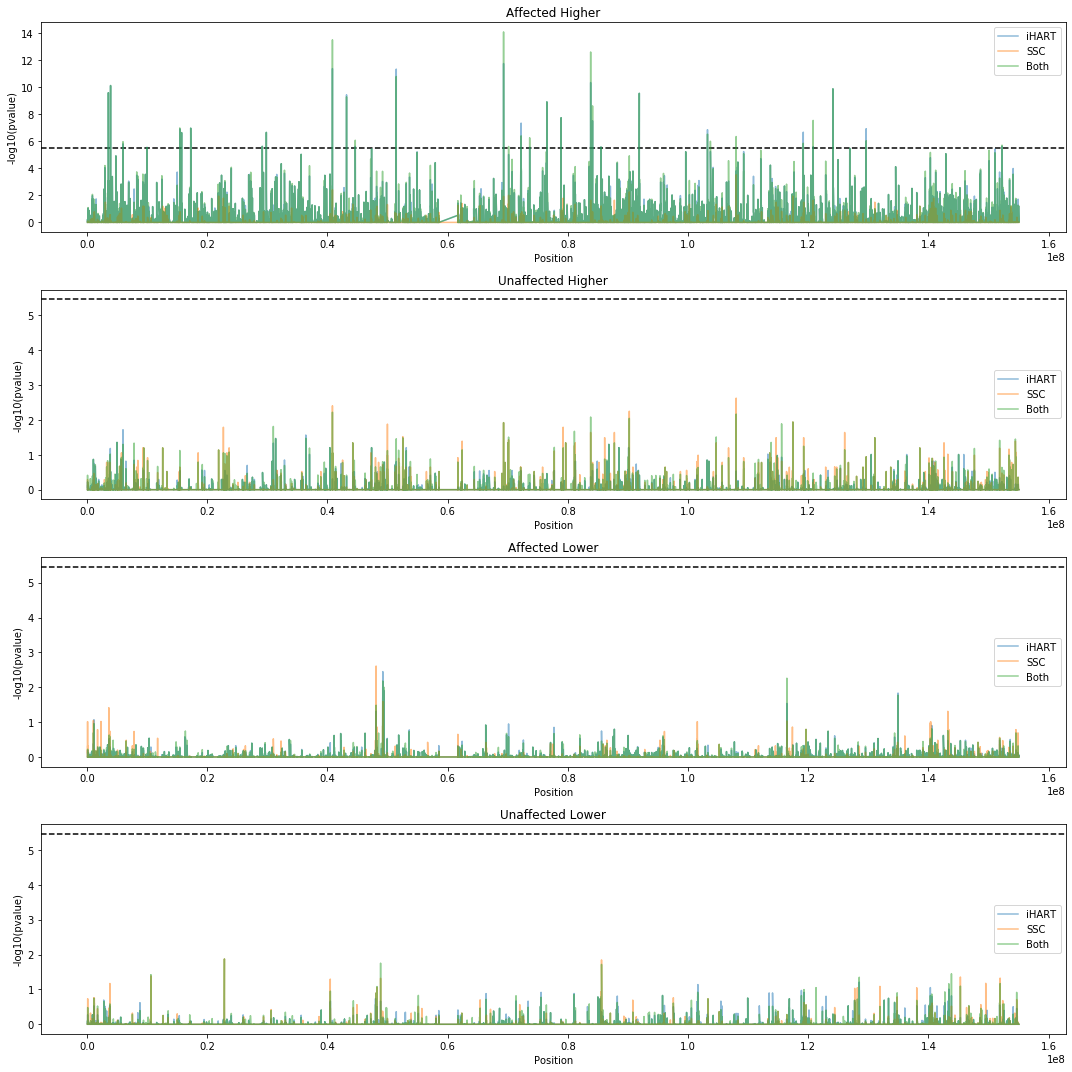

In [71]:
plt.figure(figsize=(15, 15))
 
#cutoff = -np.log10(0.05/len(contingency_both_aff))
cutoff = -np.log10(0.05/len(all_collections))

plt.subplot(4, 1, 1)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Affected Higher')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(pvalues_ihart_aff[ind_indices, -1, 0]), alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(pvalues_ssc_aff[ind_indices, -1, 0]), alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(pvalues_both_aff[ind_indices, -1, 0]), alpha=0.5, label='Both')
plt.legend()

plt.subplot(4, 1, 2)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Unaffected Higher')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(pvalues_ihart_unaff[ind_indices, -1, 0]), alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(pvalues_ssc_unaff[ind_indices, -1, 0]), alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(pvalues_both_unaff[ind_indices, -1, 0]), alpha=0.5, label='Both')
plt.legend()

plt.subplot(4, 1, 3)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Affected Lower')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(pvalues_ihart_aff[ind_indices, -1, 1]), alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(pvalues_ssc_aff[ind_indices, -1, 1]), alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(pvalues_both_aff[ind_indices, -1, 1]), alpha=0.5, label='Both')
plt.legend()

plt.subplot(4, 1, 4)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Unaffected Lower')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(pvalues_ihart_unaff[ind_indices, -1, 1]), alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(pvalues_ssc_unaff[ind_indices, -1, 1]), alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(pvalues_both_unaff[ind_indices, -1, 1]), alpha=0.5, label='Both')
plt.legend()

plt.tight_layout()
plt.show()

In [72]:
print('iHART')
for i in np.where(-np.log10(pvalues_ihart_aff[ind_indices, -1, 0]) > cutoff)[0]:
    i = np.where(ind_indices)[0][i]
    d = all_collections[i].deletion
    print('%s:%d-%d %d %d' % (d.chrom, d.start_pos, d.end_pos, d.length, d.opt_end_pos-d.opt_start_pos))
    print(i, pvalues_ihart_aff[i, -1, 0])

print('SSC')
for i in np.where(-np.log10(pvalues_ssc_aff[ind_indices, -1, 0]) > cutoff)[0]:
    i = np.where(ind_indices)[0][i]
    d = all_collections[i].deletion
    print('%s:%d-%d %d %d' % (d.chrom, d.start_pos, d.end_pos, d.length, d.opt_end_pos-d.opt_start_pos))
    
print('Both')
for i in np.where(-np.log10(pvalues_both_aff[ind_indices, -1, 0]) > cutoff)[0]:
    i = np.where(ind_indices)[0][i]
    d = all_collections[i].deletion
    print('%s:%d-%d %d %d' % (d.chrom, d.start_pos, d.end_pos, d.length, d.opt_end_pos-d.opt_start_pos))
    print(i, pvalues_ihart_aff[i, -1, 0])
# X:5055345-5057501 

iHART
X:3531186-3531189 4 3
705 2.574423229110315e-10
X:3896897-3896939 43 42
814 1.1399556218992727e-07
X:3896931-3896939 9 8
816 7.626066217513758e-11
X:5964901-5964903 3 2
1093 1.566067525742521e-06
X:9955037-9955039 3 2
1524 2.8532867643514197e-06
X:15414898-15414903 6 5
1836 1.2307652840501078e-07
X:15721965-15721999 35 34
1848 2.300780244518856e-07
X:17233254-17233258 5 4
1934 1.0731913349775419e-07
X:29147730-29147735 6 5
2827 2.3867869624610973e-06
X:29821545-29821656 112 111
2915 2.2085445260073638e-07
X:29821545-29821565 21 20
2916 1.0175463975147892e-06
X:40821707-40822467 761 760
3727 2.215830683681722e-10
X:40821874-40822073 200 199
3728 4.274890602711898e-12
X:40822307-40822483 177 176
3729 7.023168828885477e-12
X:40822415-40822586 172 171
3733 5.168734328862257e-07
X:40822415-40822536 122 121
3734 3.2899693138980355e-11
X:43168703-43168742 40 39
3914 3.7102681132186276e-10
X:43168966-43169396 431 430
3915 5.634561016208764e-10
X:44622965-44622969 5 4
4027 2.4184485480929

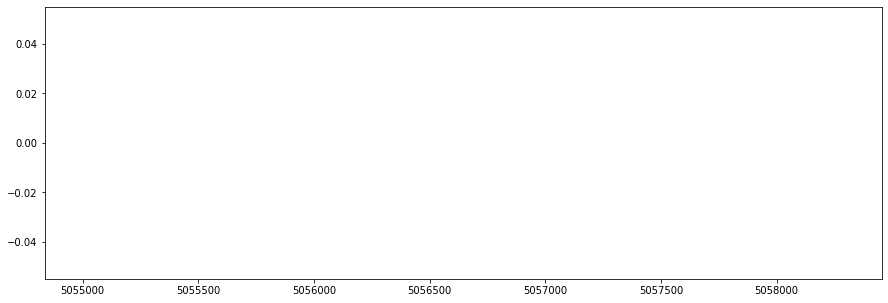

In [73]:
plt.figure(figsize=(15, 5))

plt.hist([m.start_pos for m in all_collections[276].matches], alpha=0.5, bins=np.arange(5055000, 5058300, 10))
plt.hist([m.end_pos for m in all_collections[276].matches], alpha=0.5, bins=np.arange(5055000, 5058300, 10))
plt.show()

0.48523206751054854
0.8189300411522634
0.7372116349047142
0.8420467185761957


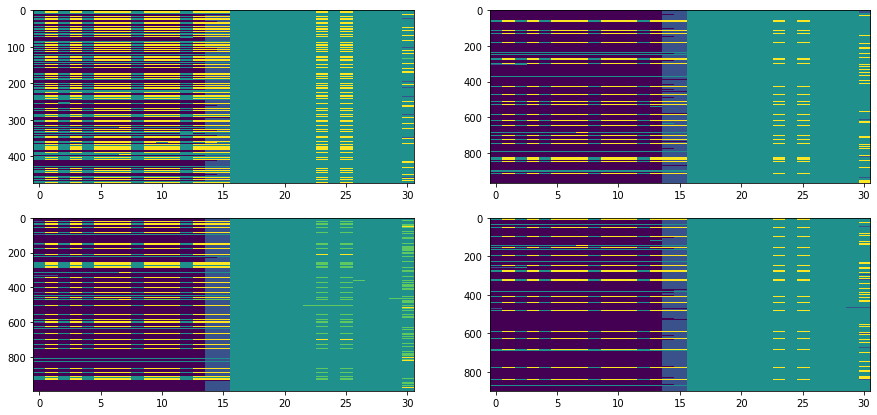

In [74]:
plt.figure(figsize=(15, 7))

indices = (snp_positions>=5055352) & (snp_positions<=5058099)
index = 1
moms = set([inds[0] for inds in fam_to_inds.values()])
dads = set([inds[1] for inds in fam_to_inds.values()])

mom_has_dd = set([m for m in moms if m in sample_id_to_index and A[sample_id_to_index[m], indices].A[0, index]<0])
children = set(sum([inds[2:] for inds in fam_to_inds.values() if inds[0] not in mom_has_dd], []))


plt.subplot(2, 2, 1)
aut_indices = [sample_id_to_index[s] for s in children if (s in child_id_to_affected) and (child_id_to_affected[s]=='2') and (child_id_to_sex[s]=='1') and (s in sample_id_to_index)]
plt.imshow(A[np.ix_(aut_indices, indices)].A, aspect='auto')
print(np.sum(A[np.ix_(aut_indices, indices)].A[:, index]<0)/len(aut_indices))

plt.subplot(2, 2, 2)
typ_indices = [sample_id_to_index[s] for s in children if (s in child_id_to_affected) and (child_id_to_affected[s]=='1') and (child_id_to_sex[s]=='1') and (s in sample_id_to_index)]
plt.imshow(A[np.ix_(typ_indices, indices)].A, aspect='auto')
print(np.sum(A[np.ix_(typ_indices, indices)].A[:, index]<0)/len(typ_indices))

plt.subplot(2, 2, 3)
mom_indices = [sample_id_to_index[s] for s in moms if (s in sample_id_to_index)]
plt.imshow(A[np.ix_(mom_indices, indices)].A, aspect='auto')
print(np.sum(A[np.ix_(mom_indices, indices)].A[:, index]<0)/len(mom_indices))

plt.subplot(2, 2, 4)
dad_indices = [sample_id_to_index[s] for s in dads if (s in sample_id_to_index)]
plt.imshow(A[np.ix_(dad_indices, indices)].A, aspect='auto')
print(np.sum(A[np.ix_(dad_indices, indices)].A[:, index]<0)/len(dad_indices))

plt.show()

In [75]:
import bayesian_transmission_rate as btr
import importlib
importlib.reload(btr)

#ihart
transrates_ihart_aff = btr.calculate_transmission_rates(contingency_ihart_aff, ihart_family_sizes)
transrates_ihart_unaff = btr.calculate_transmission_rates(contingency_ihart_unaff, ihart_family_sizes)

transrates_ihart_aff_m = btr.calculate_transmission_rates(contingency_ihart_aff_m, ihart_family_sizes)
transrates_ihart_unaff_m = btr.calculate_transmission_rates(contingency_ihart_unaff_m, ihart_family_sizes)

transrates_ihart_aff_f = btr.calculate_transmission_rates(contingency_ihart_aff_f, ihart_family_sizes)
transrates_ihart_unaff_f = btr.calculate_transmission_rates(contingency_ihart_unaff_f, ihart_family_sizes)

transrates_ihart_all = btr.calculate_transmission_rates(contingency_ihart_all, ihart_family_sizes)

#ssc
transrates_ssc_aff = btr.calculate_transmission_rates(contingency_ssc_aff, ihart_family_sizes)
transrates_ssc_unaff = btr.calculate_transmission_rates(contingency_ssc_unaff, ihart_family_sizes)

transrates_ssc_aff_m = btr.calculate_transmission_rates(contingency_ssc_aff_m, ihart_family_sizes)
transrates_ssc_unaff_m = btr.calculate_transmission_rates(contingency_ssc_unaff_m, ihart_family_sizes)

transrates_ssc_aff_f = btr.calculate_transmission_rates(contingency_ssc_aff_f, ihart_family_sizes)
transrates_ssc_unaff_f = btr.calculate_transmission_rates(contingency_ssc_unaff_f, ihart_family_sizes)

#both
transrates_both_aff = btr.calculate_transmission_rates(contingency_both_aff, ihart_family_sizes)
transrates_both_unaff = btr.calculate_transmission_rates(contingency_both_unaff, ihart_family_sizes)

transrates_both_aff_m = btr.calculate_transmission_rates(contingency_both_aff_m, ihart_family_sizes)
transrates_both_unaff_m = btr.calculate_transmission_rates(contingency_both_unaff_m, ihart_family_sizes)

transrates_both_aff_f = btr.calculate_transmission_rates(contingency_both_aff_f, ihart_family_sizes)
transrates_both_unaff_f = btr.calculate_transmission_rates(contingency_both_unaff_f, ihart_family_sizes)


In [77]:
plt.scatter(np.clip(np.array(num_support)[ind_indices], None, 20), transrates_ihart_aff[ind_indices], alpha=0.1)
plt.scatter(np.clip(np.array(num_support)[ind_indices], None, 20), transrates_ihart_unaff[ind_indices], alpha=0.1)

plt.ylabel('Trans Rate')
plt.xlabel('Supporting Sites')
plt.axhline(0.5, color='black', linestyle='--')

plt.ylim([0, 1])

plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 12697 but corresponding boolean dimension is 14513

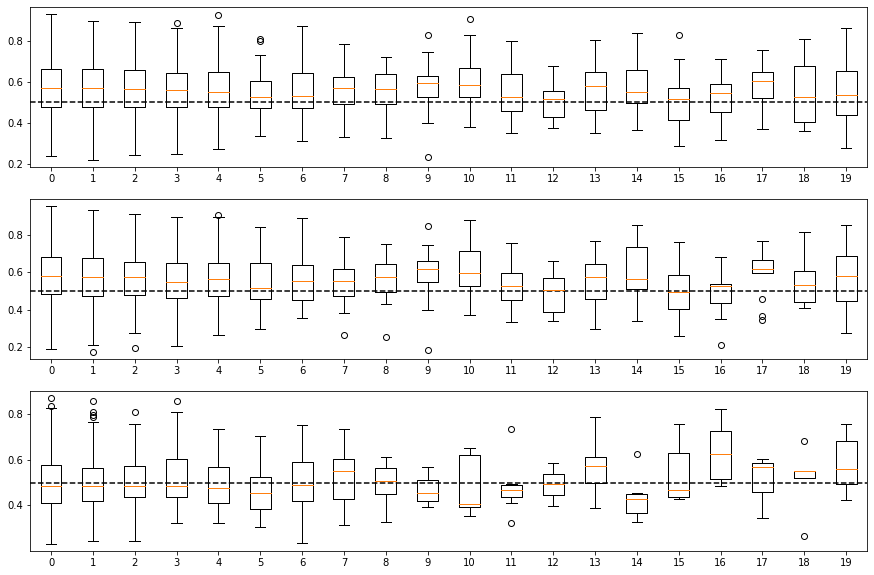

In [78]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
bp_data = []
for i in range(20):
    d = transrates_ihart_all[np.where(np.array(num_support)==i)[0]]
    bp_data.append(d[~np.isnan(d)])
plt.boxplot(bp_data)
plt.axhline(0.5, color='black', linestyle='--')
plt.xticks(range(1, 21), ['%d' % i for i in range(20)])

plt.subplot(3, 1, 2)
bp_data = []
for i in range(20):
    d = transrates_ihart_aff[np.where(np.array(num_support)==i)[0]]
    bp_data.append(d[~np.isnan(d)])
plt.boxplot(bp_data)
plt.axhline(0.5, color='black', linestyle='--')
plt.xticks(range(1, 21), ['%d' % i for i in range(20)])

plt.subplot(3, 1, 3)
bp_data = []
for i in range(20):
    d = transrates_ihart_unaff[np.where(np.array(num_support)==i)[0]]
    bp_data.append(d[~np.isnan(d)])
plt.boxplot(bp_data)
plt.axhline(0.5, color='black', linestyle='--')
plt.xticks(range(1, 21), ['%d' % i for i in range(20)])

plt.show()

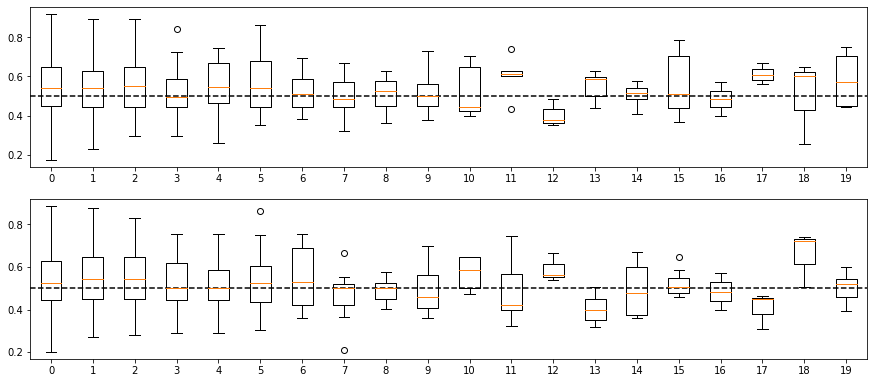

In [79]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 2)
bp_data = []
for i in range(20):
    d = transrates_ssc_aff[np.where(np.array(num_support)==i)[0]]
    bp_data.append(d[~np.isnan(d)])
plt.boxplot(bp_data)
plt.axhline(0.5, color='black', linestyle='--')
plt.xticks(range(1, 21), ['%d' % i for i in range(20)])

plt.subplot(3, 1, 3)
bp_data = []
for i in range(20):
    d = transrates_ssc_unaff[np.where(np.array(num_support)==i)[0]]
    bp_data.append(d[~np.isnan(d)])
plt.boxplot(bp_data)
plt.axhline(0.5, color='black', linestyle='--')
plt.xticks(range(1, 21), ['%d' % i for i in range(20)])

plt.show()

//anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6721: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
//anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6722: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
//anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
//anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


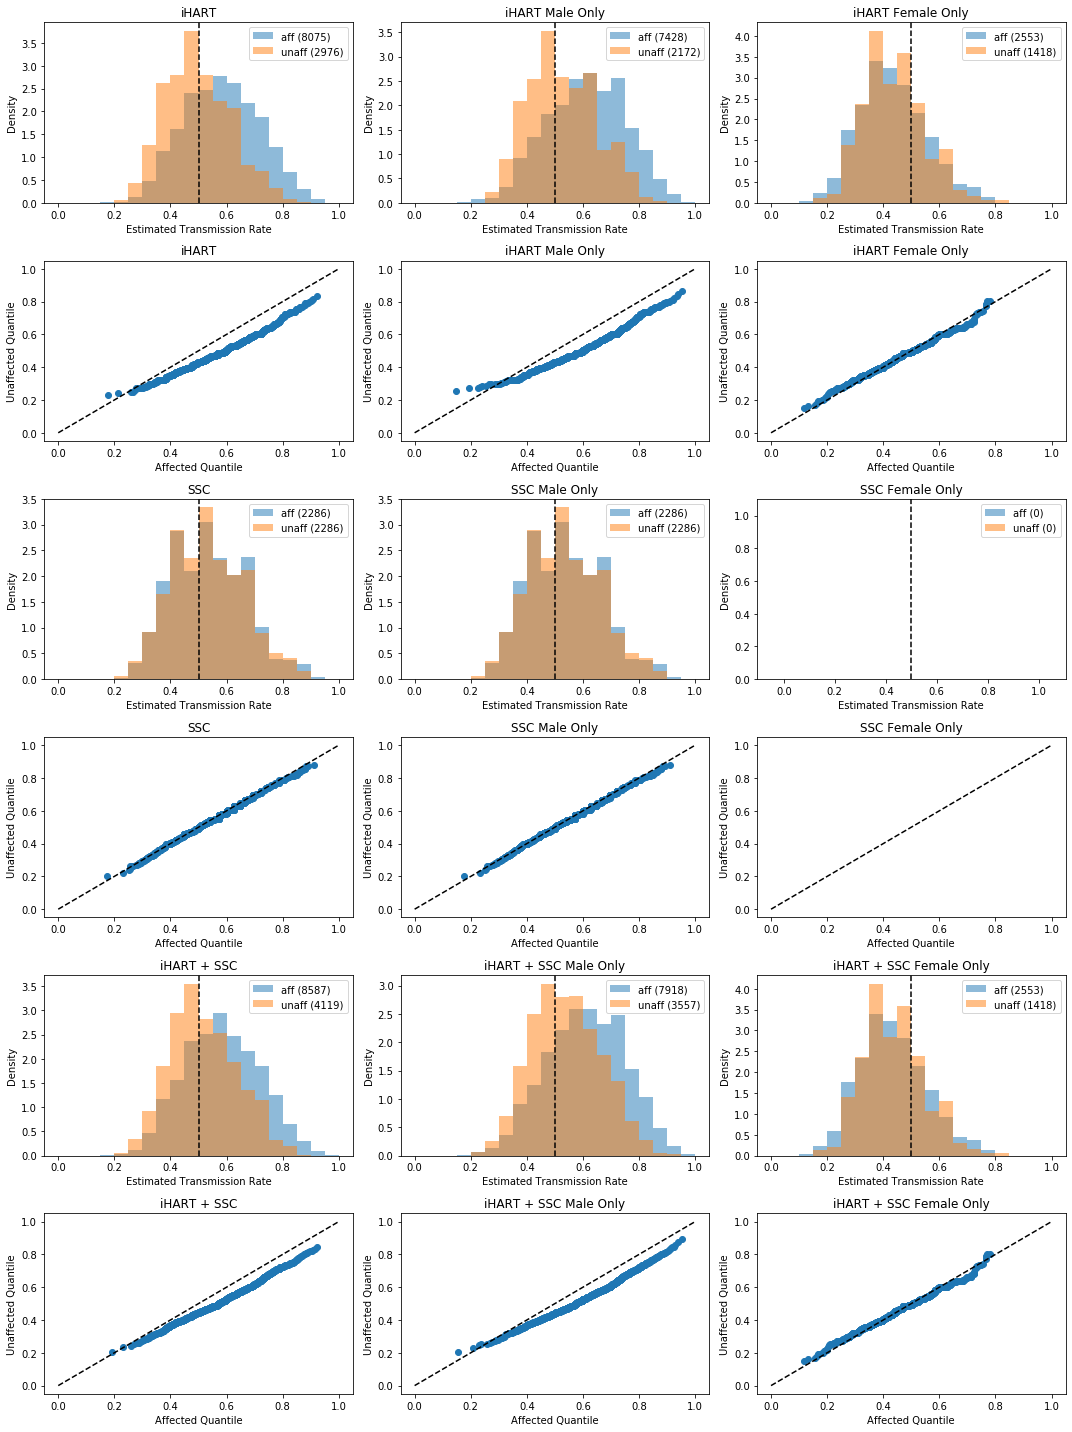

In [80]:
plt.figure(figsize=(15, 20))

bin_size = 0.05
bins = np.arange(0, 1+bin_size, bin_size)

# --------- iHART ---------

#hist
plt.subplot(6, 3, 1)
plt.hist(transrates_ihart_aff[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ihart_aff[ind_indices])), density=True)
plt.hist(transrates_ihart_unaff[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ihart_unaff[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 2)
plt.hist(transrates_ihart_aff_m[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ihart_aff_m[ind_indices])), density=True)
plt.hist(transrates_ihart_unaff_m[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ihart_unaff_m[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 3)
plt.hist(transrates_ihart_aff_f[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ihart_aff_f[ind_indices])), density=True)
plt.hist(transrates_ihart_unaff_f[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ihart_unaff_f[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

# quantiles
plt.subplot(6, 3, 4)
plt.scatter(np.nanquantile(transrates_ihart_aff[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ihart_unaff[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 5)
plt.scatter(np.nanquantile(transrates_ihart_aff_m[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ihart_unaff_m[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART Male Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 6)
plt.scatter(np.nanquantile(transrates_ihart_aff_f[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ihart_unaff_f[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART Female Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

# --------- SSC ---------

#hist
plt.subplot(6, 3, 7)
plt.hist(transrates_ssc_aff[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ssc_aff[ind_indices])), density=True)
plt.hist(transrates_ssc_unaff[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ssc_unaff[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 8)
plt.hist(transrates_ssc_aff_m[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ssc_aff_m[ind_indices])), density=True)
plt.hist(transrates_ssc_unaff_m[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ssc_unaff_m[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 9)
plt.hist(transrates_ssc_aff_f[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ssc_aff_f[ind_indices])), density=True)
plt.hist(transrates_ssc_unaff_f[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ssc_unaff_f[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

# quantiles
plt.subplot(6, 3, 10)
plt.scatter(np.nanquantile(transrates_ssc_aff[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ssc_unaff[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SSC')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 11)
plt.scatter(np.nanquantile(transrates_ssc_aff_m[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ssc_unaff_m[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SSC Male Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 12)
plt.scatter(np.nanquantile(transrates_ssc_aff_f[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ssc_unaff_f[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SSC Female Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

# --------- Both ---------

#hist
plt.subplot(6, 3, 13)
plt.hist(transrates_both_aff[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_both_aff[ind_indices])), density=True)
plt.hist(transrates_both_unaff[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_both_unaff[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 14)
plt.hist(transrates_both_aff_m[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_both_aff_m[ind_indices])), density=True)
plt.hist(transrates_both_unaff_m[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_both_unaff_m[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 15)
plt.hist(transrates_both_aff_f[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_both_aff_f[ind_indices])), density=True)
plt.hist(transrates_both_unaff_f[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_both_unaff_f[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

# quantiles
plt.subplot(6, 3, 16)
plt.scatter(np.nanquantile(transrates_both_aff[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_both_unaff[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART + SSC')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 17)
plt.scatter(np.nanquantile(transrates_both_aff_m[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_both_unaff_m[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART + SSC Male Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 18)
plt.scatter(np.nanquantile(transrates_both_aff_f[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_both_unaff_f[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART + SSC Female Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.tight_layout()
plt.show()


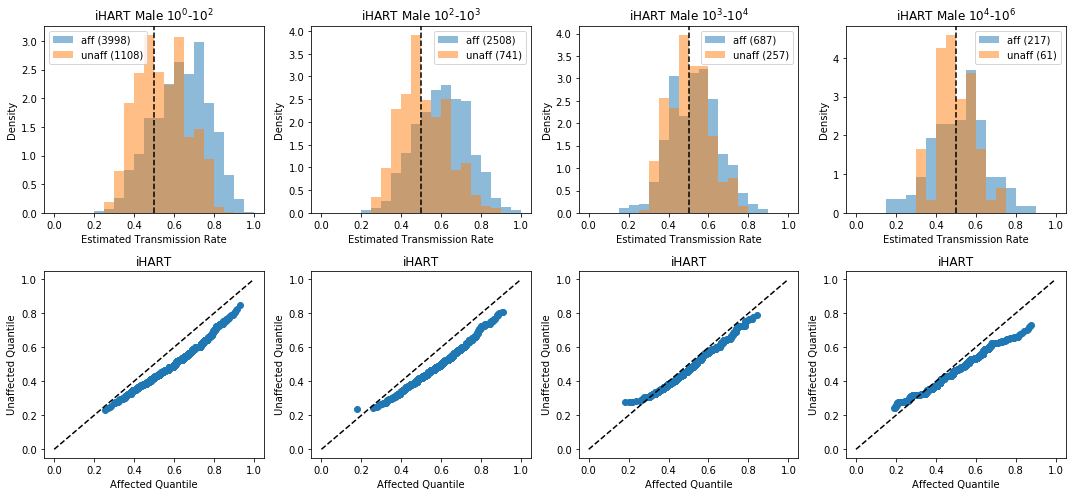

In [81]:
plt.figure(figsize=(15, 7))

b = [0, 2, 3, 4, 6]
for i in range(len(b)-1):
    plt.subplot(2, 4, i+1)
    right_size = np.array([c.deletion.length > pow(10, b[i]) and c.deletion.length < pow(10, b[i+1]) for c in all_collections])
    plt.hist(transrates_ihart_aff_m[ind_indices & right_size], bins=bins, 
             alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ihart_aff_m[ind_indices & right_size])), density=True)
    plt.hist(transrates_ihart_unaff_m[ind_indices & right_size], bins=bins, 
             alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ihart_unaff_m[ind_indices & right_size])), density=True)
    plt.axvline(0.5, color='black', linestyle='--')
    plt.legend()
    plt.title('iHART Male $10^%d$-$10^%d$' % (b[i], b[i+1]))
    plt.xlabel('Estimated Transmission Rate')
    plt.ylabel('Density')
    
    plt.subplot(2, 4, i+5)
    plt.scatter(np.nanquantile(transrates_ihart_aff[ind_indices & right_size], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ihart_unaff[ind_indices & right_size], np.arange(0, 1, 0.001)))
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.title('iHART')
    plt.xlabel('Affected Quantile')
    plt.ylabel('Unaffected Quantile')
    
plt.tight_layout()
plt.show()

In [82]:
importlib.reload(btr)

#ihart
posteriors_ihart_aff = btr.calculate_posteriors(contingency_ihart_aff, ihart_family_sizes)
posteriors_ihart_unaff = btr.calculate_posteriors(contingency_ihart_unaff, ihart_family_sizes)

posteriors_ihart_aff_m = btr.calculate_posteriors(contingency_ihart_aff_m, ihart_family_sizes)
posteriors_ihart_unaff_m = btr.calculate_posteriors(contingency_ihart_unaff_m, ihart_family_sizes)

posteriors_ihart_aff_f = btr.calculate_posteriors(contingency_ihart_aff_f, ihart_family_sizes)
posteriors_ihart_unaff_f = btr.calculate_posteriors(contingency_ihart_unaff_f, ihart_family_sizes)

#ssc
posteriors_ssc_aff = btr.calculate_posteriors(contingency_ssc_aff, ihart_family_sizes)
posteriors_ssc_unaff = btr.calculate_posteriors(contingency_ssc_unaff, ihart_family_sizes)

posteriors_ssc_aff_m = btr.calculate_posteriors(contingency_ssc_aff_m, ihart_family_sizes)
posteriors_ssc_unaff_m = btr.calculate_posteriors(contingency_ssc_unaff_m, ihart_family_sizes)

posteriors_ssc_aff_f = btr.calculate_posteriors(contingency_ssc_aff_f, ihart_family_sizes)
posteriors_ssc_unaff_f = btr.calculate_posteriors(contingency_ssc_unaff_f, ihart_family_sizes)

#both
posteriors_both_aff = btr.calculate_posteriors(contingency_both_aff, ihart_family_sizes)
posteriors_both_unaff = btr.calculate_posteriors(contingency_both_unaff, ihart_family_sizes)

posteriors_both_aff_m = btr.calculate_posteriors(contingency_both_aff_m, ihart_family_sizes)
posteriors_both_unaff_m = btr.calculate_posteriors(contingency_both_unaff_m, ihart_family_sizes)

posteriors_both_aff_f = btr.calculate_posteriors(contingency_both_aff_f, ihart_family_sizes)
posteriors_both_unaff_f = btr.calculate_posteriors(contingency_both_unaff_f, ihart_family_sizes)


//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


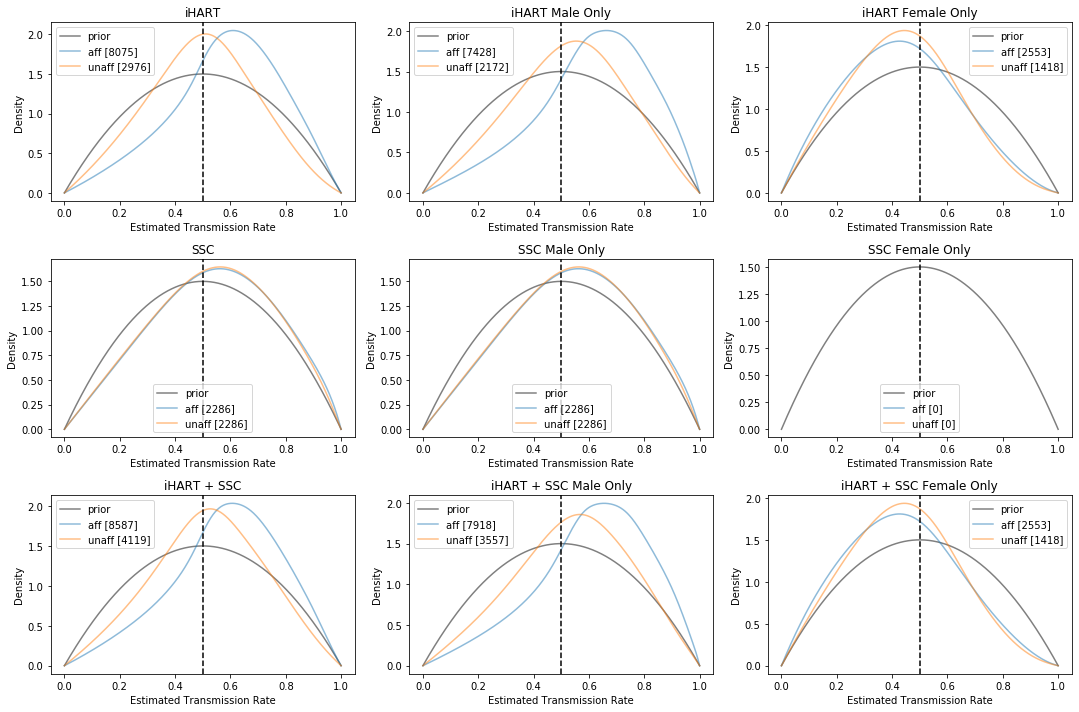

In [83]:
plt.figure(figsize=(15, 10))

ps = np.arange(0, 1.001, 0.001)
na_cutoff = 5

# --------- iHART ---------

#hist
plt.subplot(3, 3, 1)
these_indices = ind_indices & (np.sum(contingency_ihart_aff, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, btr.prior, 
         alpha=0.5, label='prior', color='black')
plt.plot(ps, np.sum(posteriors_ihart_aff[these_indices, :]/n, axis=0), 
         alpha=0.5, label='aff [%d]' % n)
these_indices = ind_indices & (np.sum(contingency_ihart_unaff, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, np.sum(posteriors_ihart_unaff[these_indices, :]/n, axis=0), 
         alpha=0.5, label='unaff [%d]' % n)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 2)
these_indices = ind_indices & (np.sum(contingency_ihart_aff_m, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, btr.prior, 
         alpha=0.5, label='prior', color='black')
plt.plot(ps, np.sum(posteriors_ihart_aff_m[these_indices, :]/n, axis=0), 
         alpha=0.5, label='aff [%d]' % n)
these_indices = ind_indices & (np.sum(contingency_ihart_unaff_m, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, np.sum(posteriors_ihart_unaff_m[these_indices, :]/n, axis=0), 
         alpha=0.5, label='unaff [%d]' % n)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 3)
these_indices = ind_indices & (np.sum(contingency_ihart_aff_f, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, btr.prior, 
         alpha=0.5, label='prior', color='black')
plt.plot(ps, np.sum(posteriors_ihart_aff_f[these_indices, :]/n, axis=0), 
         alpha=0.5, label='aff [%d]' % n)
these_indices = ind_indices & (np.sum(contingency_ihart_unaff_f, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, np.sum(posteriors_ihart_unaff_f[these_indices, :]/n, axis=0), 
         alpha=0.5, label='unaff [%d]' % n)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

# --------- SSC ---------

#hist
plt.subplot(3, 3, 4)
these_indices = ind_indices & (np.sum(contingency_ssc_aff, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, btr.prior, 
         alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_ssc_aff[these_indices, :], axis=0)
s = np.std(posteriors_ssc_aff[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_ssc_unaff, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
x = np.mean(posteriors_ssc_unaff[these_indices, :], axis=0)
s = np.std(posteriors_ssc_unaff[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 5)
these_indices = ind_indices & (np.sum(contingency_ssc_aff_m, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, btr.prior, 
         alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_ssc_aff_m[these_indices, :], axis=0)
s = np.std(posteriors_ssc_aff_m[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_ssc_unaff_m, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
x = np.mean(posteriors_ssc_unaff_m[these_indices, :], axis=0)
s = np.std(posteriors_ssc_unaff_m[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 6)
these_indices = ind_indices & (np.sum(contingency_ssc_aff_f, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, btr.prior, 
         alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_ssc_aff_f[these_indices, :], axis=0)
s = np.std(posteriors_ssc_aff_f[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_ssc_unaff_f, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
x = np.mean(posteriors_ssc_unaff_f[these_indices, :], axis=0)
s = np.std(posteriors_ssc_unaff_f[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

# --------- Both ---------

#hist
plt.subplot(3, 3, 7)
these_indices = ind_indices & (np.sum(contingency_both_aff, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, btr.prior,  alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_both_aff[these_indices, :], axis=0)
s = np.std(posteriors_both_aff[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_aff[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_aff[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_both_unaff, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
x = np.mean(posteriors_both_unaff[these_indices, :], axis=0)
s = np.std(posteriors_both_unaff[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_unaff[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_unaff[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 8)
these_indices = ind_indices & (np.sum(contingency_both_aff_m, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, btr.prior, 
         alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_both_aff_m[these_indices, :], axis=0)
s = np.std(posteriors_both_aff_m[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_aff_m[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_aff_m[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_both_unaff_m, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
x = np.mean(posteriors_both_unaff_m[these_indices, :], axis=0)
s = np.std(posteriors_both_unaff_m[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_unaff_m[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_unaff_m[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 9)
these_indices = ind_indices & (np.sum(contingency_both_aff_f, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
plt.plot(ps, btr.prior, 
         alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_both_aff_f[these_indices, :], axis=0)
s = np.std(posteriors_both_aff_f[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_aff_f[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_aff_f[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_both_unaff_f, axis=(1, 2))>=na_cutoff)
n = np.sum(these_indices)
x = np.mean(posteriors_both_unaff_f[these_indices, :], axis=0)
s = np.std(posteriors_both_unaff_f[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_unaff_f[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_unaff_f[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [84]:

overlap_ihart = btr.calculate_posterior_overlap(posteriors_ihart_aff, posteriors_ihart_unaff)
overlap_ihart_m = btr.calculate_posterior_overlap(posteriors_ihart_aff_m, posteriors_ihart_unaff_m)
overlap_ihart_f = btr.calculate_posterior_overlap(posteriors_ihart_aff_f, posteriors_ihart_unaff_f)
print(np.min(overlap_ihart), np.min(overlap_ihart_m), np.min(overlap_ihart_f))

overlap_ssc = btr.calculate_posterior_overlap(posteriors_ssc_aff, posteriors_ssc_unaff)
overlap_ssc_m = btr.calculate_posterior_overlap(posteriors_ssc_aff_m, posteriors_ssc_unaff_m)
overlap_ssc_f = btr.calculate_posterior_overlap(posteriors_ssc_aff_f, posteriors_ssc_unaff_f)
print(np.min(overlap_ssc), np.min(overlap_ssc_m), np.min(overlap_ssc_f))

overlap_both = btr.calculate_posterior_overlap(posteriors_both_aff, posteriors_both_unaff)
overlap_both_m = btr.calculate_posterior_overlap(posteriors_both_aff_m, posteriors_both_unaff_m)
overlap_both_f = btr.calculate_posterior_overlap(posteriors_both_aff_f, posteriors_both_unaff_f)
print(np.min(overlap_both), np.min(overlap_both_m), np.min(overlap_both_f))

0.001328721719203529 0.002562583350489073 0.047147108676769724
0.061361953843709356 0.061361953843709356 1.0
0.001354880098795799 0.004678120700778938 0.047147108676769724


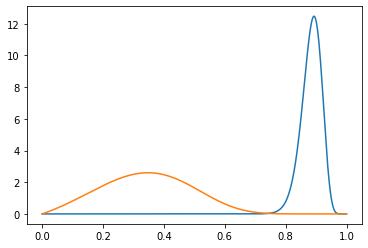

In [85]:
plt.plot(ps, posteriors_both_aff[np.argmin(overlap_both), :])
plt.plot(ps, posteriors_both_unaff[np.argmin(overlap_both), :])
plt.show()

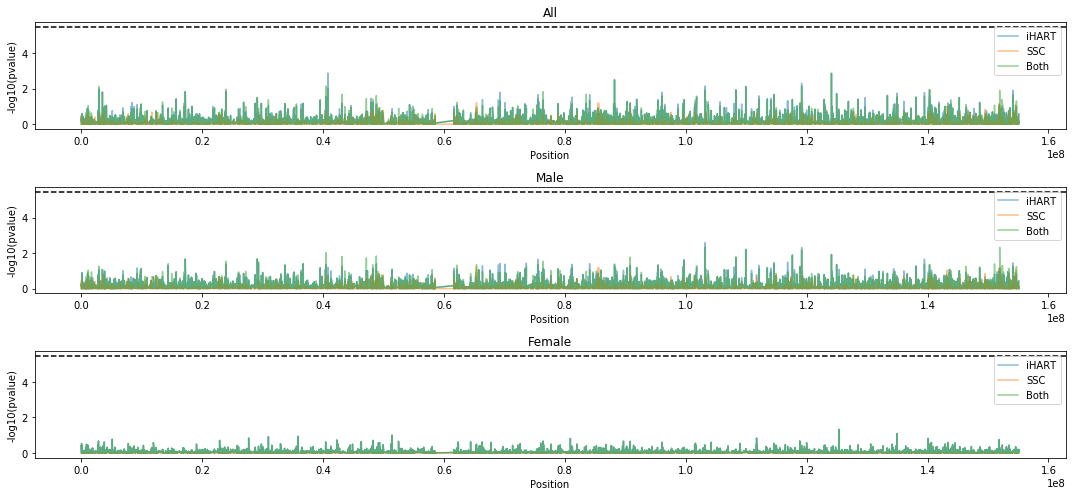

In [86]:
plt.figure(figsize=(15, 7))
 
#cutoff = -np.log10(0.05/len(contingency_both_aff))
#cutoff = -np.log10(0.05/len(all_collections))
#cutoff = -np.log10(0.05/np.sum(num_support>=support_cutoff))
cutoff = -np.log10(0.05/np.sum(ind_indices))

plt.subplot(3, 1, 1)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('All')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(overlap_ihart)[ind_indices], alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(overlap_ssc)[ind_indices], alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(overlap_both)[ind_indices], alpha=0.5, label='Both')
plt.legend()

plt.subplot(3, 1, 2)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Male')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(overlap_ihart_m)[ind_indices], alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(overlap_ssc_m)[ind_indices], alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(overlap_both_m)[ind_indices], alpha=0.5, label='Both')
plt.legend()

plt.subplot(3, 1, 3)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Female')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(overlap_ihart_f)[ind_indices], alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(overlap_ssc_f)[ind_indices], alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(overlap_both_f)[ind_indices], alpha=0.5, label='Both')
plt.legend()

plt.tight_layout()
plt.show()

In [87]:


#ihart
posterior_pvalues_ihart_aff = btr.calculate_posterior_pvalue(posteriors_ihart_aff)
posterior_pvalues_ihart_unaff =  btr.calculate_posterior_pvalue(posteriors_ihart_unaff)

#ssc
posterior_pvalues_ssc_aff =  btr.calculate_posterior_pvalue(posteriors_ssc_aff)
posterior_pvalues_ssc_unaff =  btr.calculate_posterior_pvalue(posteriors_ssc_unaff)

#both
posterior_pvalues_both_aff =  btr.calculate_posterior_pvalue(posteriors_both_aff)
posterior_pvalues_both_unaff =  btr.calculate_posterior_pvalue(posteriors_both_unaff)


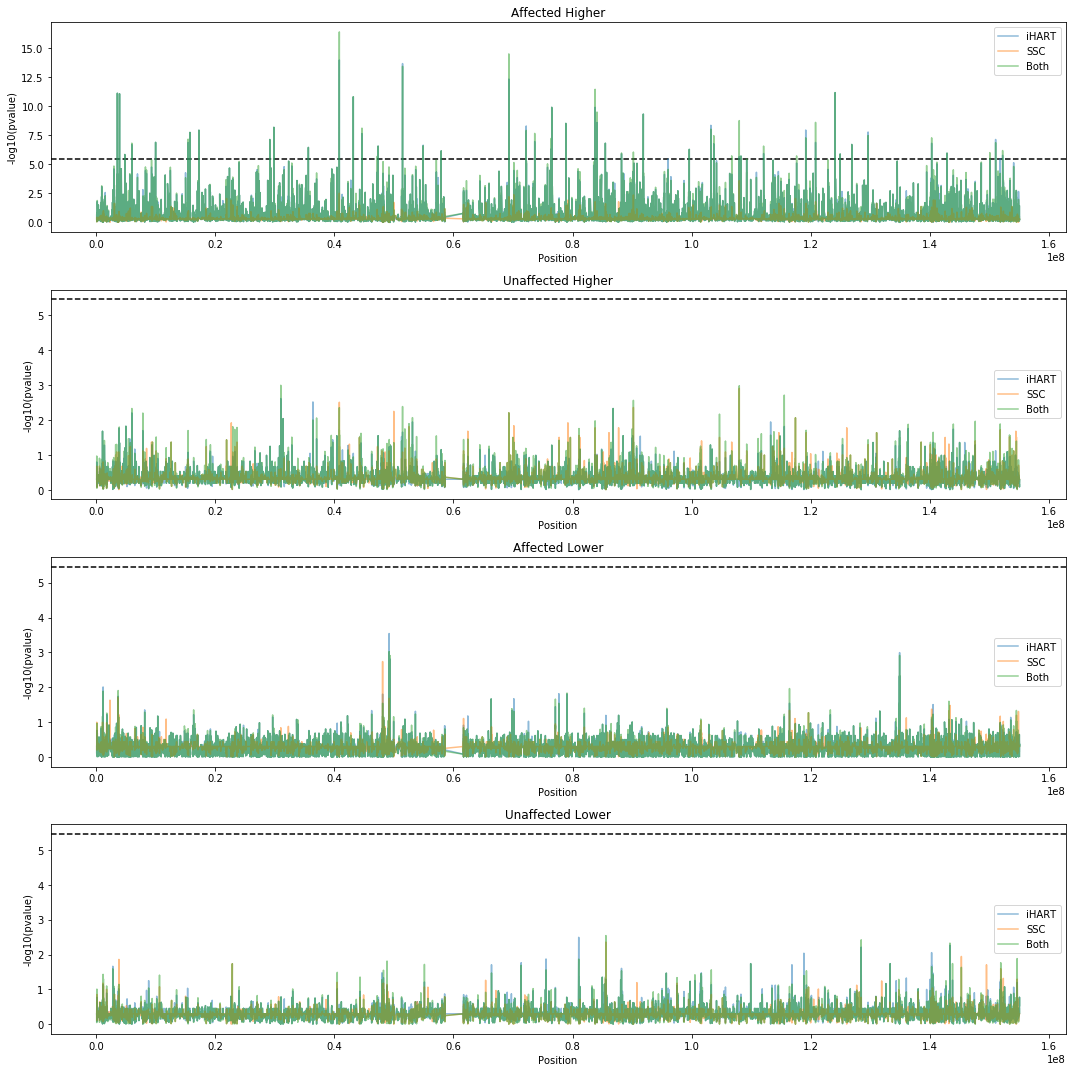

In [88]:
plt.figure(figsize=(15, 15))
 
plt.subplot(4, 1, 1)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Affected Higher')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_ihart_aff[ind_indices, 0]), alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_ssc_aff[ind_indices, 0]), alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_both_aff[ind_indices, 0]), alpha=0.5, label='Both')
plt.legend()

plt.subplot(4, 1, 2)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Unaffected Higher')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_ihart_unaff[ind_indices, 0]), alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_ssc_unaff[ind_indices, 0]), alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_both_unaff[ind_indices, 0]), alpha=0.5, label='Both')
plt.legend()

plt.subplot(4, 1, 3)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Affected Lower')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_ihart_aff[ind_indices, 1]), alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_ssc_aff[ind_indices, 1]), alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_both_aff[ind_indices, 1]), alpha=0.5, label='Both')
plt.legend()

plt.subplot(4, 1, 4)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Unaffected Lower')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_ihart_unaff[ind_indices, 1]), alpha=0.5, label='iHART')
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_ssc_unaff[ind_indices, 1]), alpha=0.5, label='SSC')
plt.plot(positions[ind_indices], -np.log10(posterior_pvalues_both_unaff[ind_indices, 1]), alpha=0.5, label='Both')
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
for i in np.where((-np.log10(posterior_pvalues_ihart_aff[:, 0]) > cutoff) & ind_indices)[0]:
    d = all_collections[i].deletion
    print('%s:%d-%d %d %d %d' % (d.chrom, d.start_pos, d.end_pos, d.length, d.opt_end_pos-d.opt_start_pos, num_support[i]))
    print(np.hstack((contingency_ihart_aff[i, :, :], contingency_ihart_unaff[i, :, :])))
    print(np.hstack((contingency_ssc_aff[i, :, :], contingency_ssc_unaff[i, :, :])))
    
    print(ind_indices[i])
    #print([(x.family, x.family_size) for x in all_collections[i].matches])
#X:5054906-5058099 2748 3193
#X:51275126-51275296 15 170
#X:69302767-69303266 98 499
#X:83796555-83796931 182 376   
    

X:3531186-3531189 4 3 0
[[ 0.  0.  0.  0.]
 [ 0. 20.  0.  2.]
 [ 1. 41.  5. 10.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
True
X:3896897-3896939 43 42 0
[[ 0.  0.  0.  0.]
 [ 0. 19.  0.  1.]
 [ 4. 40.  3. 13.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
True
X:3896931-3896939 9 8 0
[[ 0.  0.  0.  0.]
 [ 0. 33.  0.  1.]
 [ 6. 51.  5. 16.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
True
X:4782658-4782660 3 2 0
[[ 0.  0.  0.  0.]
 [ 0. 21.  0.  1.]
 [ 3. 24.  2. 10.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
True
X:5964901-5964903 3 2 0
[[ 0.  0.  0.  0.]
 [ 0. 20.  0.  0.]
 [ 7. 41.  1. 14.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
True
X:9955037-9955039 3 2 0
[[ 0.  0.  0.  0.]
 [ 0. 13.  0.  1.]
 [ 2. 31.  3.  6.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
T

IndexError: list index out of range

In [ ]:
# 1KG Chromosome X: 5055345-5057501 Xp22.32
# 1KG Chromosome X: 69303060-69303274 Xq13.1 

#AWAT2, 
# IGBP1 (linked to mental retardation)
# corpus callosum, agenesis of, with mental retardation, ocular coloboma, and micrognathia
# linked to Opitz-Gbbb syndrome either X-linked or 22q11.2 deletion, problem with midline
# labrythinitis (inflamation of the inner ear)
# autosomal dominant alport syndrome: kidney disease, hearing loss, eye abnormalities
# Opitz-Kaveggia Syndrome - intellectual disability, macrocephaly, abnormalities of the corpus callosum


In [ ]:
plt.scatter(np.hstack(transrates_ihart_aff), np.hstack(transrates_ihart_unaff), alpha=0.1)

indices = (num_support>=support_cutoff) & (-np.log10(np.vstack(posterior_pvalues_ihart_aff))[:, 0]>=cutoff)
plt.scatter(np.hstack(transrates_ihart_aff)[indices], np.hstack(transrates_ihart_unaff)[indices])
indices = (num_support>=support_cutoff) & (-np.log10(np.vstack(posterior_pvalues_ihart_unaff))[:, 0]>=cutoff)
plt.scatter(np.hstack(transrates_ihart_aff)[indices], np.hstack(transrates_ihart_unaff)[indices])
indices = (num_support>=support_cutoff) * (-np.log10(np.vstack(posterior_pvalues_ihart_aff))[:, 1]>=cutoff)
plt.scatter(np.hstack(transrates_ihart_aff)[indices], np.hstack(transrates_ihart_unaff)[indices])
indices = (num_support>=support_cutoff) & (-np.log10(np.vstack(posterior_pvalues_ihart_unaff))[:, 1]>=cutoff)
plt.scatter(np.hstack(transrates_ihart_aff)[indices], np.hstack(transrates_ihart_unaff)[indices])
plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()